In [1]:
import numpy as np
import scipy as sp
from scipy import interpolate
import cv2 as cv
import matplotlib.pyplot as plt

# Part A: Factored Sampling
This part is mostly illustrative, so you just have a few TODO's. Condensation is actually Factored Sampling, but applied iteratively to a sequence of observations, and incorporating a motion model.\
So here, time will essentially stand still: given a SINGLE set of "observations", can you estimate the posterior probabilities?\
Observations will be simulated: The real 2D distribution we would like to estimate is the red channel of an abstract image (provided).
But pretend you can't look at the whole image, and can only take measurements here and there.

Below, you have the code for factored sampling, but note the comment "Loop from here".
Looping will only be needed in PartB because we will have a changing state, so each loop will advance from $t$ to $t + 1$.
Here, you can abuse factored sampling a little, and loop "in place".
If time were advancing and you had a real motion model, that would be Condensation.\
*Observe: when you do this factored Resampling, more of the particles  should be landing near the peaks in the distribution.*

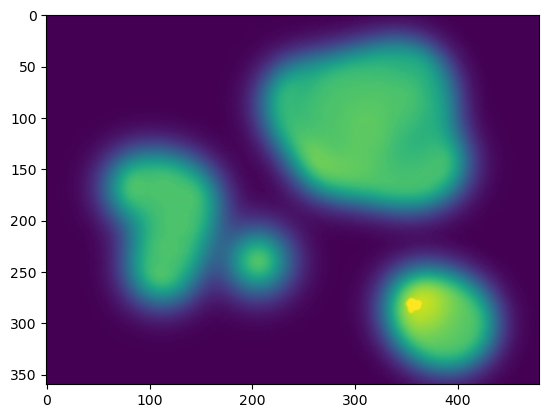

In [2]:
img = cv.imread('data/abstract.png')
measurementsComprehensive = img[:,:,2]
plt.imshow(measurementsComprehensive)
plt.show()


This is the image containing different sized peaks of different intensity's. We aim to use factored sampling to iteratively move particles to the peaks of intensity shown in the image.

In [3]:
imgHeight, imgWidth, colors = img.shape
numParticles = 150;
# Initialize which samples from "last time" we want to propagate: all of
# them!:
samples_to_propagate = range(0, numParticles)
numDims_w = 2

Iteration  0 :


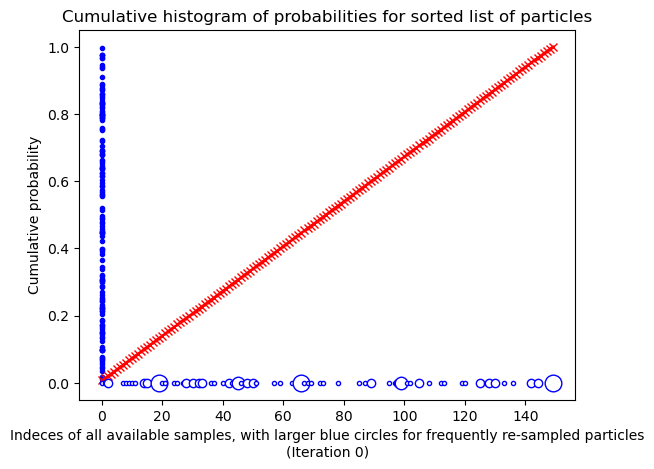

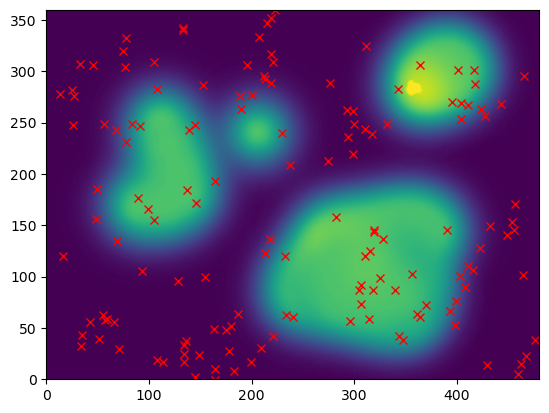

Iteration  1 :


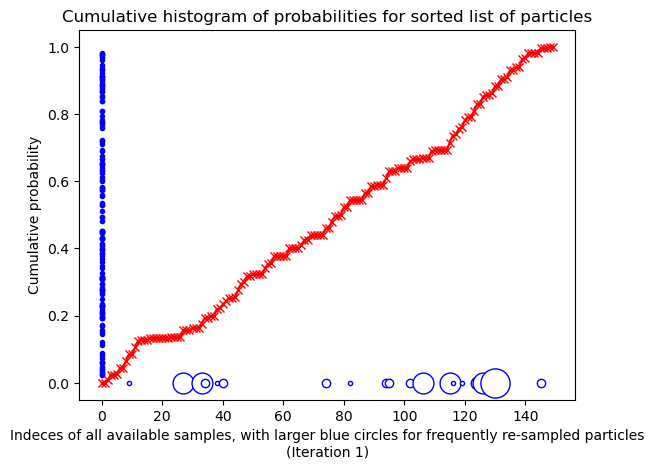

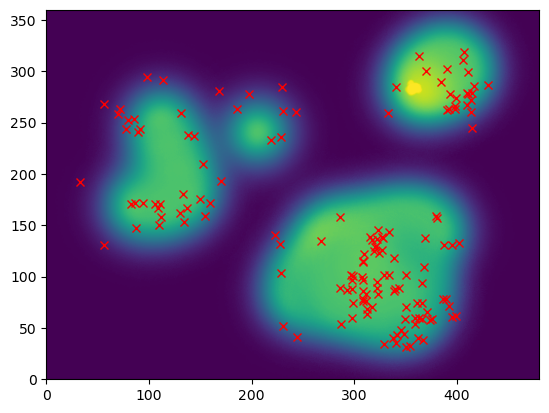

Iteration  2 :


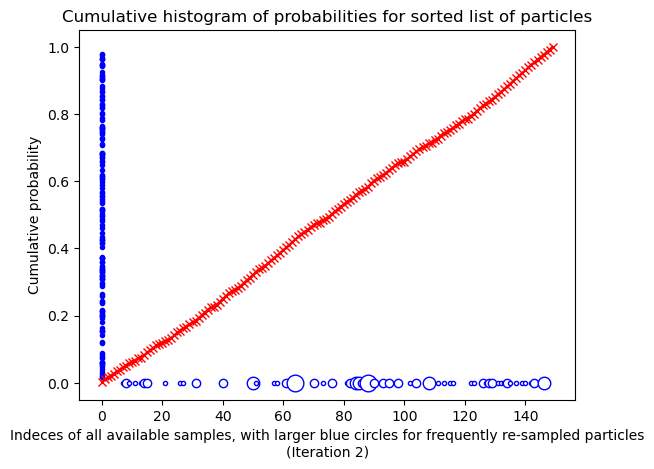

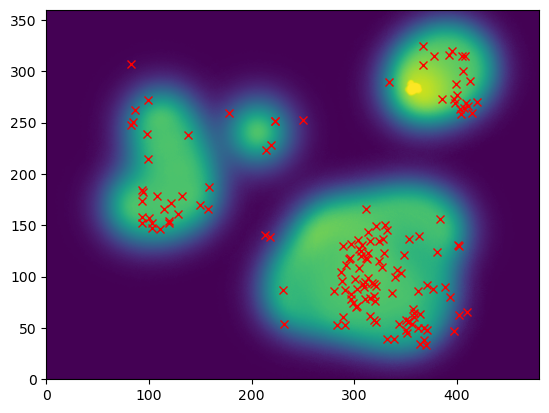

Iteration  3 :


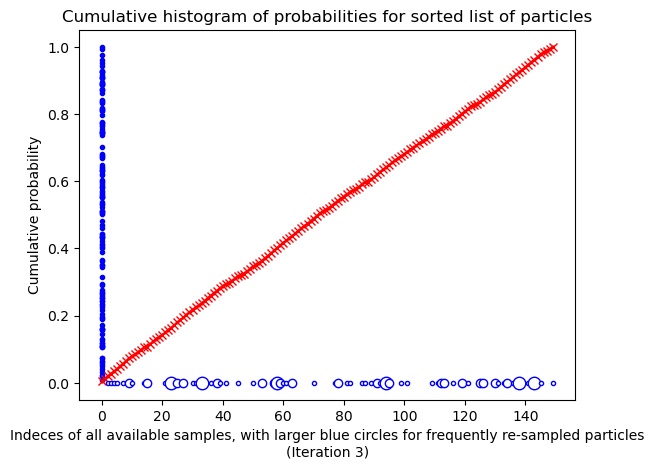

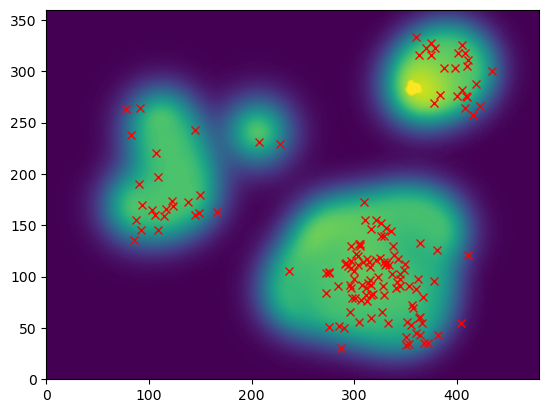

Iteration  4 :


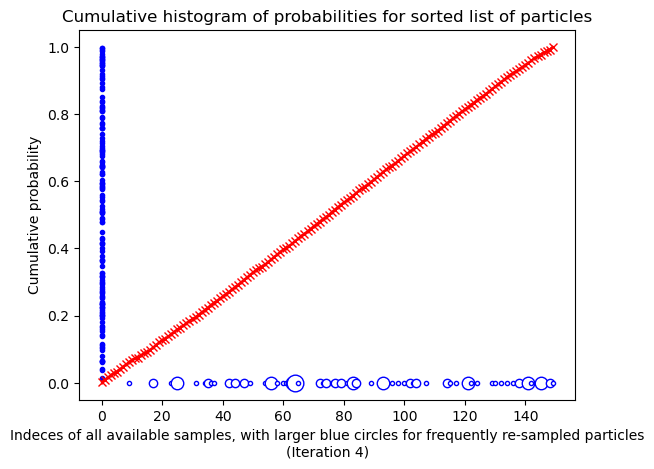

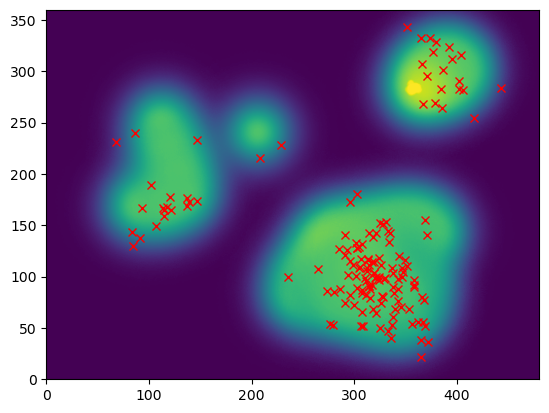

Iteration  5 :


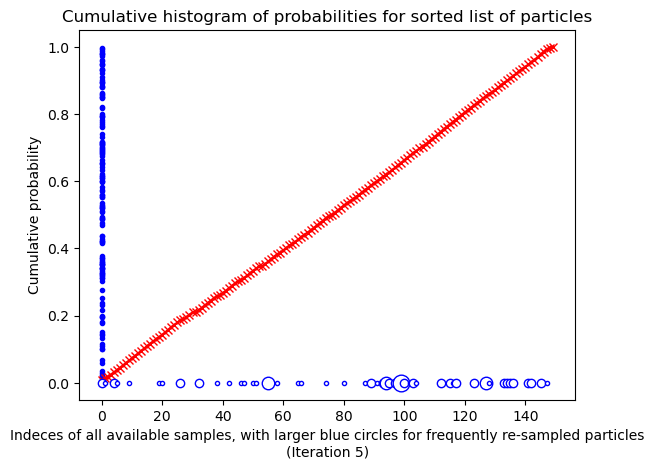

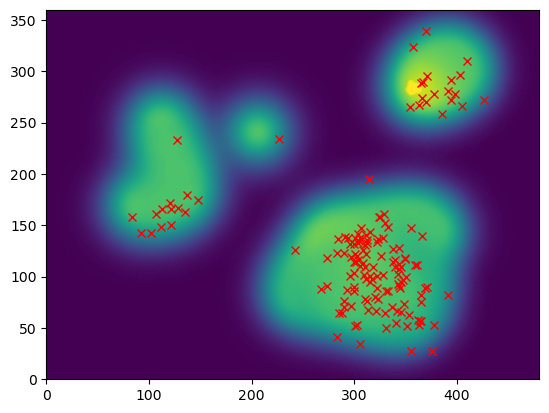

Iteration  6 :


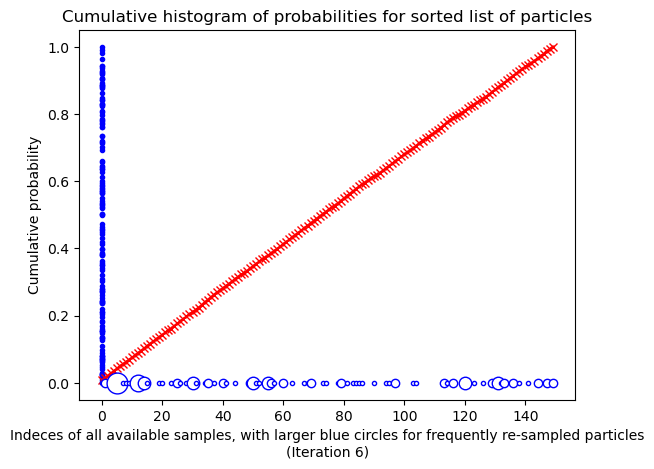

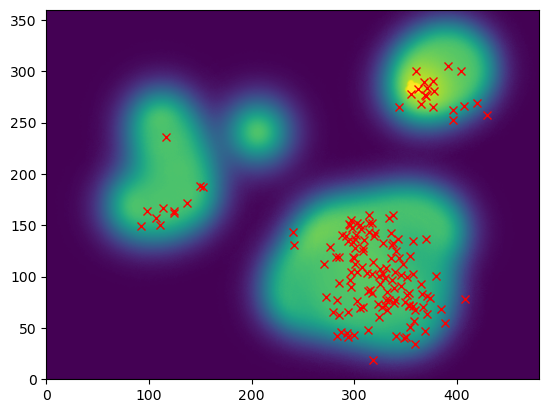

Iteration  7 :


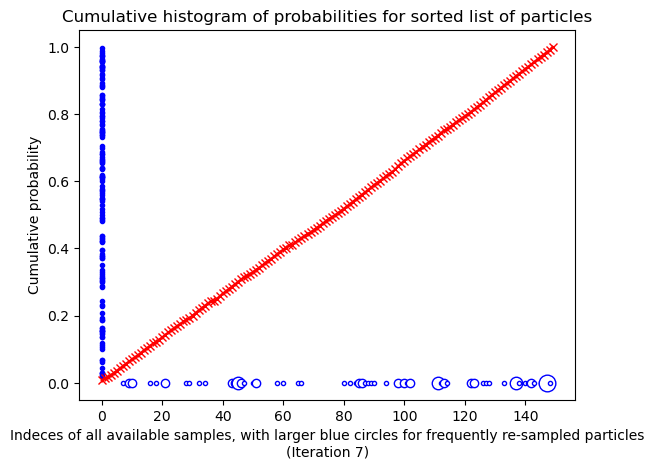

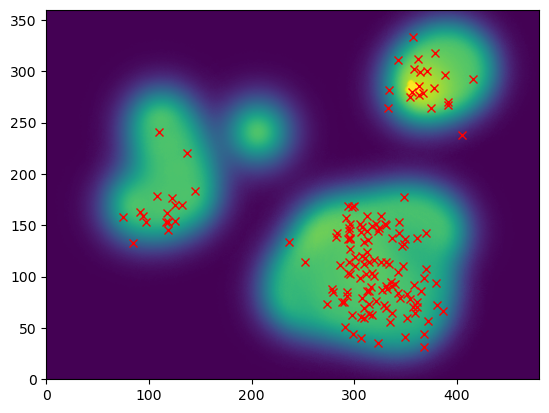

Iteration  8 :


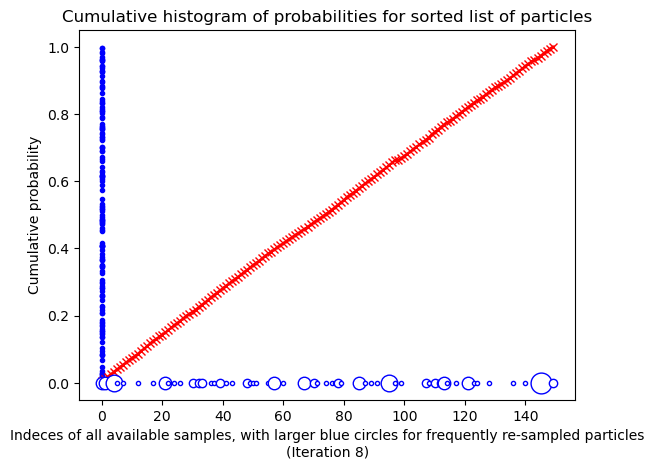

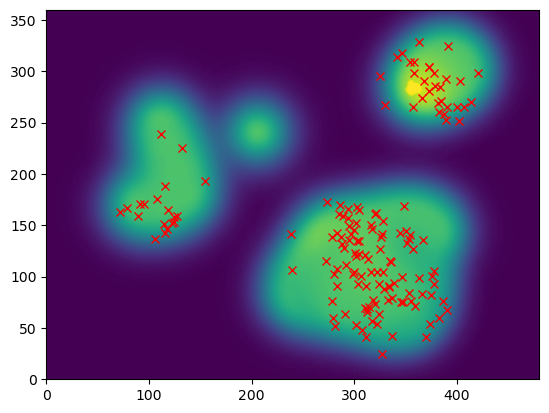

Iteration  9 :


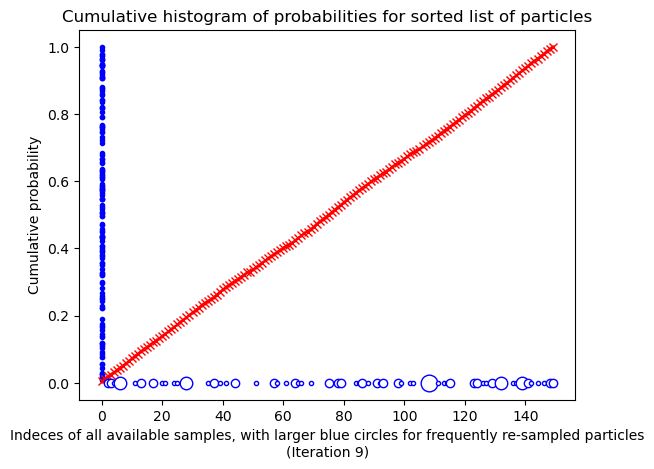

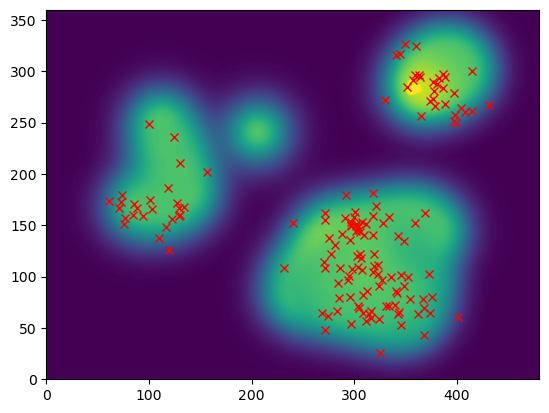

In [4]:
# Here we randomly initialize some particles throughout the space of w.
# The positions of such particles are quite close to the known initial position:
particles_old = np.random.rand(numParticles, numDims_w)

#note: clipping here is just done to simplify plotting - we want everything to 'fit'
particles_old[:,0] = particles_old[:,0] * imgHeight
particles_old[:,1] = particles_old[:,1] * imgWidth

weight_of_samples = np.ones((numParticles,1))
# TO DO (a): normalize the weights (may be trivial this time)
weight_of_samples = weight_of_samples / np.sum(weight_of_samples) 
#weight_of_samples = weight_of_samples/numParticles

# We loop here to see what factored resampling would look like.
for iTime in range(10):
    print('Iteration ', iTime, ':')
    # TO DO (b): compute the cumulative sum of the weights
    #weight_of_samples /= np.sum(weight_of_samples)
    cum_hist_of_weights = np.cumsum(weight_of_samples) # replace this 
    # Resample the old distribution (at time t-1), favoring samples that had
    # a higher posterior probability
    samples_to_propagate = np.zeros((numParticles,1), dtype=np.int32)
    
    # Pick random thresholds in the cumulative probability's range [0,1]: 
    some_threshes = np.random.rand(numParticles,1)

    # For each random threshold, find which sample in the ordered set is the
    # first one to push the cumulative probability above that threshold. 
    # E.g. if the cumulative histogram goes from 0.23 to 0.26 between the 17th
    # and 18th samples in the old distribution, and the threshold is 0.234,
    # then we'll want to propagate the 18th sample's w (i.e. particle #18).
    for sampNum in range(numParticles): 
        thresh = some_threshes[sampNum]
        for index in range(numParticles):
            if cum_hist_of_weights[index] > thresh:
                break
        samples_to_propagate[sampNum] = index
    
    # Note: it's ok if some of the old particles get picked repeatedly, while
    # others don't get picked at all.

    # =================================================
    # Visualize
    # =================================================
    plt.title('Cumulative histogram of probabilities for sorted list of particles')
    plt.plot(np.zeros(numParticles), some_threshes,'b.')
    plt.plot(range(0, numParticles), cum_hist_of_weights, 'rx-')
    which_sample_ids = np.unique(samples_to_propagate)
    how_many_of_each = np.bincount(np.ravel(samples_to_propagate))
    for k in range(len(which_sample_ids)):
        plt.plot(which_sample_ids[k], 0, 'bo-', markersize = 3 * how_many_of_each[k], markerfacecolor='white')
    plt.xlabel('Indeces of all available samples, with larger blue circles for frequently re-sampled particles\n(Iteration %01d)' % iTime)
    plt.ylabel('Cumulative probability');
    plt.show()
    # =================================================
    # =================================================

    # Predict where the particles we sampled from the old distribution of 
    # state-space will go in the next time-step. This means we have to apply 
    # the motion model to each old sample.
    particles_new = np.zeros_like(particles_old)
    for particleNum in range(numParticles):
        # TO DO (c): Incorporate some noise, e.g. Gaussian noise with std 10,
        # into the current location (particles_old), to give a Brownian
        # motion model.
        noise = 10*np.random.randn(1, 2)
        particles_new[particleNum, :] = particles_old[samples_to_propagate[particleNum], :] + noise
        
        # hint: you need to change the above line, not just add to it
        
    measurementsComprehensive = img[:,:,2]
    plt.imshow(measurementsComprehensive)
    axes = plt.gca()
    axes.set_xlim([0, imgWidth])
    axes.set_ylim([0, imgHeight])
    # now draw the particles onto the image
    plt.plot(particles_new[:,1], particles_new[:,0], 'rx')
    plt.show()

    # From here we incorporate the sensor measurement for the new state (time t):
    # The new particles, accompanied with predicted locations in world state-space
    # for time t, are missing their weights: how well does each particle
    # explain the observation x_t?
    for particleNum in range(numParticles):
        # Convert the particle from state-space w to measurement-space x:
        # Note: It is trivial in this case because both are in 2D space of image
        # coordinates

        # Within the loop, we evaluate the likelihood of each particle:
        particle = particles_new[particleNum, :]
        # Check that the predicted location is a place we can really evaluate
        # the likelihood.
        inFrame = particle[0] >= 1.0 and  particle[0] <= imgHeight and particle[1] >= 1.0 and particle[1] <= imgWidth
        if inFrame:
            interpolation_func = sp.interpolate.interp2d(np.arange(0, imgWidth),
                                                         np.arange(0, imgHeight),
                                                         measurementsComprehensive)
            weight_of_samples[particleNum] = interpolation_func(particles_new[particleNum, 1], particles_new[particleNum, 0])
        else:
            weight_of_samples[particleNum] = 0.0

    # TO DO (d): normalize the weights 
    weight_of_samples = weight_of_samples / np.sum(weight_of_samples) # replace this
    #weight_of_samples = weight_of_samples/numParticles

    # Now we're done updating the state for time t. 
    # For Condensation, just clean up and prepare for the next round of 
    # predictions and measurements:
    particles_old = particles_new;


The code creates 2 plots for each iteration. For each iteration the 1st of the figures shows the cumulative probability distribution of the samples in the previous time step with respect to their indices. The blue dots are randomly chosen thresholds between 0 and 1. The size of the other blue circles indicates how many times a sample was chosen for propagation. The larger the circle the more frequently it was chosen. The 2nd of the figures for each iteration shows the particles (red crosses) drawn onto the image. At iteration 0 we see the particles are dispersed and we aim to focus these particles onto peaks of the distribution. We see in iteration 9 this has been achieved well, although it favours the regions with larger areas. 